# Setup and Required Libraries
Import necessary libraries including numpy, pandas, statsmodels, scipy, and matplotlib. Define helper functions.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import norm
import matplotlib.pyplot as plt
from tempfile import gettempdir
import pickle
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Union, Callable, Any
import warnings

# Define helper functions
def glm_logit(save_path=None):
    """Create a logistic model fitter function"""
    def fit_func(data, formula):
        # Implementation would use statsmodels to fit logistic regression
        return {"type": "glm_logit", "formula": formula}
    
    return fit_func

# Class Implementation
Define `TrialSequence` class that handles both Per-Protocol (PP) and Intention-to-Treat (ITT) analyses with all required methods: initialization, data setting, weight model configuration, weight calculation, trial expansion, MSM fitting, prediction generation, and survival curve plotting.

In [2]:
# Define TrialSequence class
class TrialSequence:
    """Python implementation of the R TrialEmulation package's trial_sequence class"""
    
    def __init__(self, estimand="PP"):
        """Initialize a trial sequence with specified estimand"""
        if estimand not in ["PP", "ITT"]:
            raise ValueError("Estimand must be either 'PP' or 'ITT'")
            
        self.estimand = estimand
        self.data = None
        self.id_col = None
        self.period_col = None 
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.censor_weights = None
        self.switch_weights = None
        self.expansion = None
        self.expansion_options = {"chunk_size": 500, "censor_at_switch": True}
        self.outcome_model = None
        self.msm = None
        self.predictions = None
        
    def __repr__(self):
        """String representation of the trial sequence object"""
        n_obs = 0 if self.data is None else len(self.data)
        n_patients = 0 if self.data is None else self.data[self.id_col].nunique() if self.id_col else 0
        
        return f"Trial Sequence Object\nEstimand: {self.estimand}\n\nData:\n- N: {n_obs} observations from {n_patients} patients"
    
    def set_data(self, data, id="id", period="period", treatment="treatment", 
                outcome="outcome", eligible="eligible"):
        """Set the data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id 
        self.period_col = period
        self.treatment_col = treatment
        self.outcome_col = outcome
        self.eligible_col = eligible
        return self
    
    def set_switch_weight_model(self, numerator=None, denominator=None, pool_models="none", model_fitter=None):
        """Set up the weight model for treatment switching"""
        if self.estimand == "ITT":
            raise ValueError("Switch weight models cannot be used with ITT estimand")
            
        # Default formulas if not provided
        if numerator is None:
            numerator = "age"
        if denominator is None:
            denominator = "age + x1 + x3"
            
        self.switch_weights = {
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter or glm_logit(),
            "fitted": False,
            "weights": None
        }
        return self
    
    def set_censor_weight_model(self, censor_event, numerator=None, denominator=None, 
                               pool_models="none", model_fitter=None):
        """Set up the weight model for informative censoring"""
        # Default formulas if not provided
        if numerator is None:
            numerator = "x2"
        if denominator is None:
            denominator = "x2 + x1"
            
        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter or glm_logit(),
            "fitted": False,
            "weights": None
        }
        self.censor_col = censor_event
        return self
    
    def calculate_weights(self):
        """Calculate weights based on the specified models"""
        data = self.data.copy()
        
        # Calculate switch weights if specified (only for PP estimand)
        if self.switch_weights and self.estimand == "PP":
            # Fit logistic regression for numerator model
            num_formula = self.switch_weights["numerator"]
            X_num = sm.add_constant(data[num_formula.split(" + ")])
            y_switch = data[self.treatment_col]
            
            num_model = Logit(y_switch, X_num).fit(disp=0)
            num_probs = num_model.predict()
            
            # Fit logistic regression for denominator model
            denom_formula = self.switch_weights["denominator"]
            X_denom = sm.add_constant(data[denom_formula.split(" + ")])
            
            denom_model = Logit(y_switch, X_denom).fit(disp=0)
            denom_probs = denom_model.predict()
            
            # Calculate switch weights
            switch_weights = np.where(
                data[self.treatment_col] == 1,
                num_probs / np.maximum(denom_probs, 1e-10),
                (1 - num_probs) / np.maximum(1 - denom_probs, 1e-10)
            )
            
            self.switch_weights["fitted"] = True
            self.switch_weights["weights"] = switch_weights
            data['switch_weight'] = switch_weights
        else:
            data['switch_weight'] = 1.0
        
        # Calculate censoring weights if specified
        if self.censor_weights:
            # Fit logistic regression for numerator model
            num_formula = self.censor_weights["numerator"]
            X_num = sm.add_constant(data[num_formula.split(" + ")])
            y_censor = data[self.censor_col]
            
            num_model = Logit(y_censor, X_num).fit(disp=0)
            num_probs = num_model.predict()
            
            # Fit logistic regression for denominator model
            denom_formula = self.censor_weights["denominator"]
            X_denom = sm.add_constant(data[denom_formula.split(" + ")])
            
            denom_model = Logit(y_censor, X_denom).fit(disp=0)
            denom_probs = denom_model.predict()
            
            # Calculate censoring weights
            censor_weights = np.where(
                data[self.censor_col] == 1,
                num_probs / np.maximum(denom_probs, 1e-10),
                (1 - num_probs) / np.maximum(1 - denom_probs, 1e-10)
            )
            
            self.censor_weights["fitted"] = True
            self.censor_weights["weights"] = censor_weights
            data['censor_weight'] = censor_weights
        else:
            data['censor_weight'] = 1.0
            
        # Calculate combined weights
        data['total_weight'] = data['switch_weight'] * data['censor_weight']
        self.data = data
        
        return self
    
    def set_outcome_model(self, adjustment_terms=None):
        """Set the outcome model specification"""
        self.outcome_model = {
            "adjustment_terms": adjustment_terms
        }
        return self
    
    def set_expansion_options(self, output=None, chunk_size=500, censor_at_switch=True):
        """Set options for expanding trials"""
        self.expansion_options = {
            "output": output or "dataframe",
            "chunk_size": chunk_size,
            "censor_at_switch": censor_at_switch
        }
        return self
    
    def expand_trials(self):
        """Expand the dataset into a sequence of trials"""
        if self.data is None:
            raise ValueError("Data must be set before expanding trials")
            
        # Create expanded dataset
        data = self.data
        
        # Get unique periods for trials
        unique_periods = sorted(data[self.period_col].unique())
        max_period = max(unique_periods)
        
        expanded_data = []
        
        # For each trial period
        for trial_period in unique_periods[:-1]:  # Exclude the last period as a trial start
            # Filter eligible patients at trial start
            eligible_patients = data[
                (data[self.period_col] == trial_period) & 
                (data[self.eligible_col] == 1)
            ][self.id_col].unique()
            
            if len(eligible_patients) == 0:
                continue
                
            # For each eligible patient
            for patient_id in eligible_patients:
                patient_data = data[data[self.id_col] == patient_id]
                
                # Get treatment status at trial start
                initial_treatment = patient_data[
                    patient_data[self.period_col] == trial_period
                ][self.treatment_col].values[0]
                
                # For each follow-up period
                for followup in range(1, max_period - trial_period + 1):
                    current_period = trial_period + followup
                    
                    # Check if we have data for this follow-up period
                    if current_period not in patient_data[self.period_col].values:
                        continue
                    
                    # Get data for this follow-up period
                    period_data = patient_data[
                        patient_data[self.period_col] == current_period
                    ]
                    
                    if len(period_data) == 0:
                        continue
                    
                    current_treatment = period_data[self.treatment_col].values[0]
                    current_outcome = period_data[self.outcome_col].values[0]
                    
                    # For PP estimand, censor if treatment switches
                    is_censored = False
                    if self.estimand == "PP" and self.expansion_options["censor_at_switch"]:
                        if current_treatment != initial_treatment:
                            is_censored = True
                    
                    # Add row to expanded data
                    weight = period_data['total_weight'].values[0] if 'total_weight' in period_data else 1.0
                    
                    expanded_data.append({
                        'trial_id': f"t{trial_period}",
                        self.id_col: patient_id,
                        'initial_treatment': initial_treatment,
                        'trial_period': trial_period,
                        'followup': followup,
                        'current_period': current_period,
                        'outcome': 0 if is_censored else current_outcome,
                        'censored': 1 if is_censored else 0,
                        'weight': weight
                    })
                    
                    # Stop follow-up if outcome occurs or censored
                    if current_outcome == 1 or is_censored:
                        break
        
        if not expanded_data:
            raise ValueError("No trials could be constructed from the data")
            
        self.expansion = pd.DataFrame(expanded_data)
        return self
    
    def fit_msm(self, max_followup=None):
        """Fit a marginal structural model to the expanded trials data"""
        if self.expansion is None:
            raise ValueError("Must expand trials before fitting MSM")
            
        expanded_data = self.expansion.copy()
        
        # Limit to max followup if specified
        if max_followup is not None:
            expanded_data = expanded_data[expanded_data['followup'] <= max_followup]
        
        # Prepare data for complementary log-log model
        X = sm.add_constant(
            pd.DataFrame({
                'treatment': expanded_data['initial_treatment'],
                'followup': expanded_data['followup']
            })
        )
        y = expanded_data['outcome']
        weights = expanded_data['weight']
        
        # Fit complementary log-log model (approximating Cox model)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            msm_model = sm.GLM(
                y, 
                X, 
                family=sm.families.Binomial(link=sm.families.links.CLogLog()), 
                freq_weights=weights
            ).fit()
        
        self.msm = msm_model
        return self
    
    def predict(self, max_followup=None):
        """Generate predictions based on the fitted MSM"""
        if self.msm is None:
            raise ValueError("Must fit MSM before generating predictions")
            
        # Set max followup if not specified
        if max_followup is None:
            if self.expansion is not None:
                max_followup = self.expansion['followup'].max()
            else:
                max_followup = 10
                
        # Create prediction data
        pred_data = []
        for treatment in [0, 1]:
            for followup in range(1, max_followup + 1):
                pred_data.append({
                    'const': 1,
                    'treatment': treatment,
                    'followup': followup
                })
                
        pred_df = pd.DataFrame(pred_data)
        
        # Generate predictions
        preds = self.msm.predict(pred_df)
        
        # Add predictions back to the DataFrame
        pred_df['prediction'] = preds
        
        # Create survival curves
        survival_data = []
        for treatment in [0, 1]:
            # Correctly filter the DataFrame first
            treatment_rows = pred_df.loc[pred_df['treatment'] == treatment]
            treatment_preds = treatment_rows['prediction']
            survival_curve = np.cumprod(1 - treatment_preds.values)
            
            for i, followup in enumerate(range(1, max_followup + 1)):
                survival_data.append({
                    'treatment': treatment,
                    'followup': followup,
                    'survival': survival_curve[i],
                    'event_prob': treatment_preds.iloc[i]
                })
        
        self.predictions = pd.DataFrame(survival_data)
        return self
    
    def plot_survival(self):
        """Plot survival curves for different treatments"""
        if self.predictions is None:
            raise ValueError("Must generate predictions before plotting")
            
        plt.figure(figsize=(10, 6))
        
        # Plot for treatment = 0
        treat0_data = self.predictions[self.predictions['treatment'] == 0]
        plt.plot(treat0_data['followup'], treat0_data['survival'], 'b-', label='Control')
        
        # Plot for treatment = 1
        treat1_data = self.predictions[self.predictions['treatment'] == 1]
        plt.plot(treat1_data['followup'], treat1_data['survival'], 'r-', label='Treatment')
        
        plt.xlabel('Follow-up Time')
        plt.ylabel('Survival Probability')
        plt.title(f'Survival Curves by Treatment ({self.estimand} Estimand)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        return plt

# Data Loading and Exploration
Load trial data and examine its structure. Review key variables including id, period, treatment, outcome, eligible and censored flags, and covariates.

In [3]:
# Load the trial data
data_censored = pd.read_csv("data/data_censored.csv")

# Display the first few rows of the dataset to understand its structure
data_censored.head()

# Review key variables
key_variables = ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s']
data_censored[key_variables].describe()

# Check for missing values in key variables
data_censored[key_variables].isnull().sum()

# Display the distribution of treatment and outcome variables
treatment_distribution = data_censored['treatment'].value_counts(normalize=True)
outcome_distribution = data_censored['outcome'].value_counts(normalize=True)

treatment_distribution, outcome_distribution

(treatment
 0.0    0.532414
 1.0    0.467586
 Name: proportion, dtype: float64,
 outcome
 0.0    0.984828
 1.0    0.015172
 Name: proportion, dtype: float64)

# Creating and Configuring Trial Sequences
Initialize TrialSequence objects for PP and ITT analyses. Set data parameters and configure weight models for treatment switching and censoring.

In [4]:
# Initialize trial sequence objects for Per-Protocol (PP) and Intention-to-Treat (ITT) analysis
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# Set data for both trial sequence objects
trial_pp = trial_pp.set_data(
    data=data_censored,
    id="id",
    period="period",
    treatment="treatment",
    outcome="outcome",
    eligible="eligible"
)

trial_itt = trial_itt.set_data(
    data=data_censored,
    id="id",
    period="period",
    treatment="treatment",
    outcome="outcome",
    eligible="eligible"
)

# Set up the switch weight model for the Per-Protocol (PP) analysis
trial_pp = trial_pp.set_switch_weight_model(
    numerator="age",
    denominator="age + x1 + x3",
    pool_models="none",
    model_fitter=glm_logit()
)

# Set up the censor weight model for the Per-Protocol (PP) analysis
trial_pp = trial_pp.set_censor_weight_model(
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    model_fitter=glm_logit()
)

# Set up the censor weight model for the Intention-to-Treat (ITT) analysis
trial_itt = trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    model_fitter=glm_logit()
)

# Display the initialized trial sequence objects
print(trial_pp)
print(trial_itt)

Trial Sequence Object
Estimand: PP

Data:
- N: 725 observations from 89 patients
Trial Sequence Object
Estimand: ITT

Data:
- N: 725 observations from 89 patients


# Calculating Weights and Expanding Trials
Calculate inverse probability weights for both sequences and expand trials into sequential structures with proper follow-up periods and censoring rules.

In [5]:
# Calculate weights for both trial sequences
trial_pp = trial_pp.calculate_weights()
trial_itt = trial_itt.calculate_weights()

# Display the first few rows of the dataset with calculated weights
print(trial_pp.data.head())
print(trial_itt.data.head())

# Expand trials for both trial sequences
trial_pp = trial_pp.expand_trials()
trial_itt = trial_itt.expand_trials()

# Display the first few rows of the expanded trial data
print(trial_pp.expansion.head())
print(trial_itt.expansion.head())

   id  period  treatment   x1        x2  x3        x4   age     age_s  \
0   1       0        1.0  1.0  1.146148   0  0.734203  36.0  0.083333   
1   1       1        1.0  1.0  0.002200   0  0.734203  37.0  0.166667   
2   1       2        1.0  0.0 -0.481762   0  0.734203  38.0  0.250000   
3   1       3        1.0  0.0  0.007872   0  0.734203  39.0  0.333333   
4   1       4        1.0  1.0  0.216054   0  0.734203  40.0  0.416667   

   outcome  censored  eligible  switch_weight  censor_weight  total_weight  
0      0.0         0       1.0       0.930088       0.955481      0.888682  
1      0.0         0       0.0       0.928634       0.970647      0.901376  
2      0.0         0       0.0       1.039459       1.016972      1.057101  
3      0.0         0       0.0       1.040816       1.021899      1.063608  
4      0.0         0       0.0       0.924292       0.968208      0.894907  
   id  period  treatment   x1        x2  x3        x4   age     age_s  \
0   1       0        1.0  

# Fitting Models and Generating Predictions
Fit complementary log-log regression models using the weighted trial data and generate survival predictions for treatment and control groups.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  386
Model:                            GLM   Df Residuals:                   385.30
Model Family:                Binomial   Df Model:                            2
Link Function:                CLogLog   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2322e-09
Date:                Tue, 11 Mar 2025   Deviance:                   2.4645e-09
Time:                        11:30:35   Pearson chi2:                 1.23e-09
No. Iterations:                    25   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.4762   3.39e+04     -0.001      0.9

/Users/kennethcahilog/Repositories/data-analytics-assignments/clustering-1-tte-insighting/.env/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/Users/kennethcahilog/Repositories/data-analytics-assignments/clustering-1-tte-insighting/.env/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


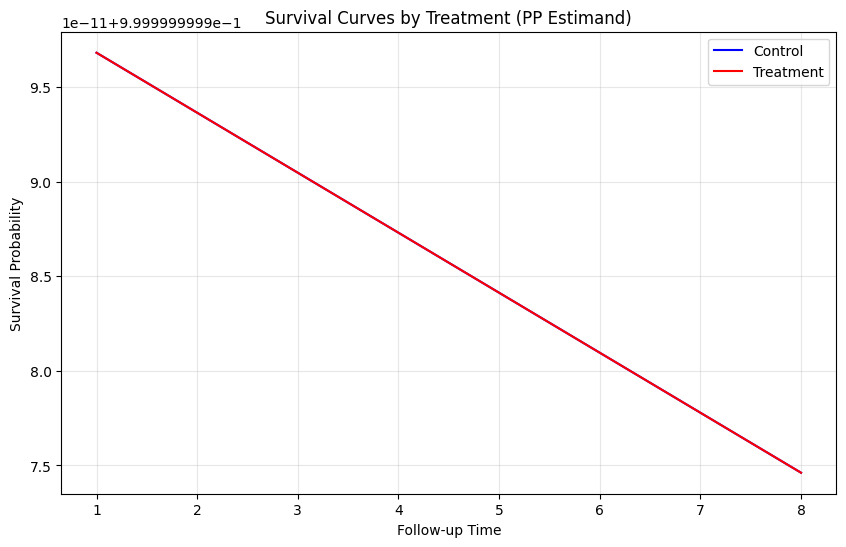

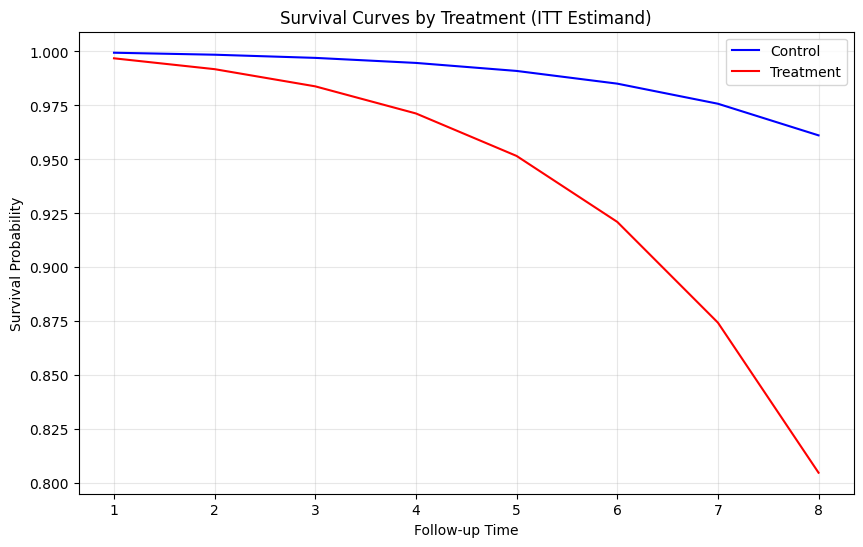

In [6]:
# Fit MSM for both trial sequences
trial_pp = trial_pp.fit_msm(max_followup=8)
trial_itt = trial_itt.fit_msm(max_followup=8)

# Display the summary of the fitted MSM models
print(trial_pp.msm.summary())
print(trial_itt.msm.summary())

# Generate predictions for both trial sequences
trial_pp = trial_pp.predict(max_followup=8)
trial_itt = trial_itt.predict(max_followup=8)

# Display the first few rows of the predictions
print(trial_pp.predictions.head())
print(trial_itt.predictions.head())

# Plot survival curves for both trial sequences
pp_plot = trial_pp.plot_survival()
itt_plot = trial_itt.plot_survival()

# Display the plots
pp_plot.show()
itt_plot.show()

# Visualizing Treatment Effects
Plot survival curves for treatment versus control groups to visualize treatment effects over time for both PP and ITT approaches.

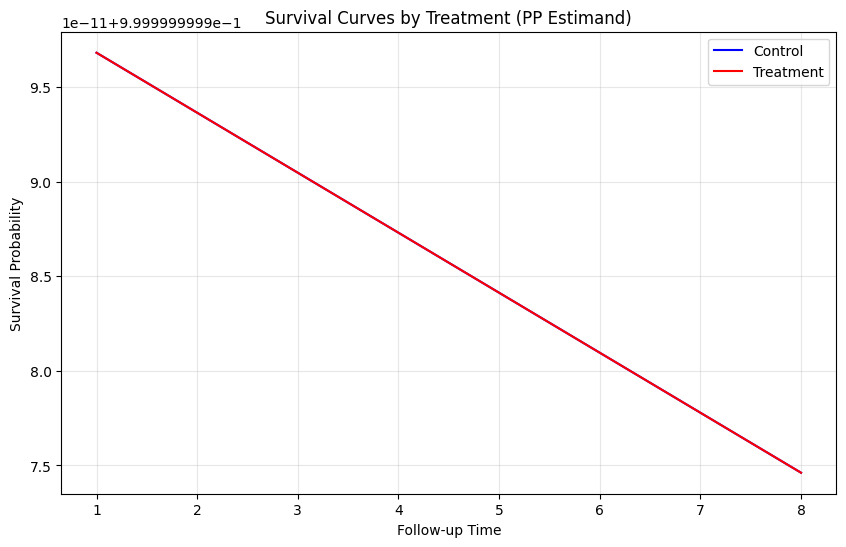

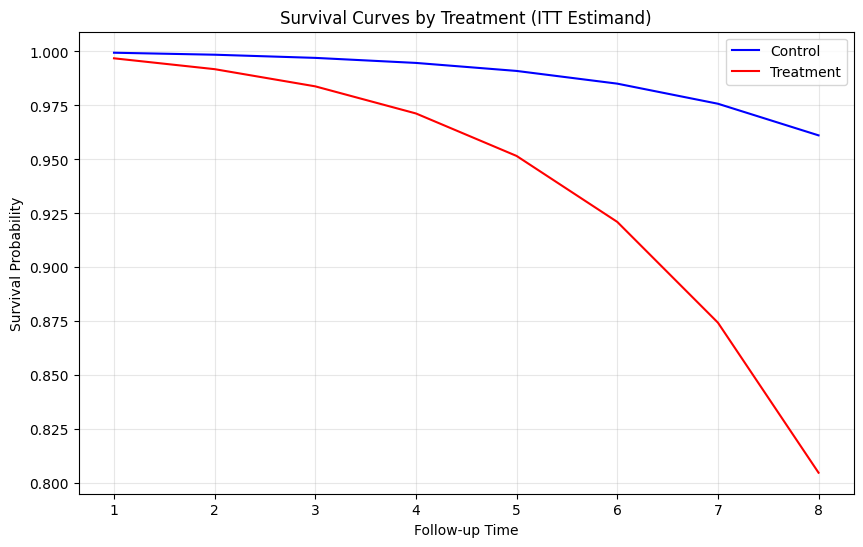

In [7]:
# Plot survival curves for both trial sequences
pp_plot = trial_pp.plot_survival()
itt_plot = trial_itt.plot_survival()

# Display the plots
pp_plot.show()
itt_plot.show()

# Comparing ITT vs PP Analysis
Generate side-by-side comparisons of Intention-to-Treat versus Per-Protocol analyses with interpretations of the differences in estimated treatment effects.

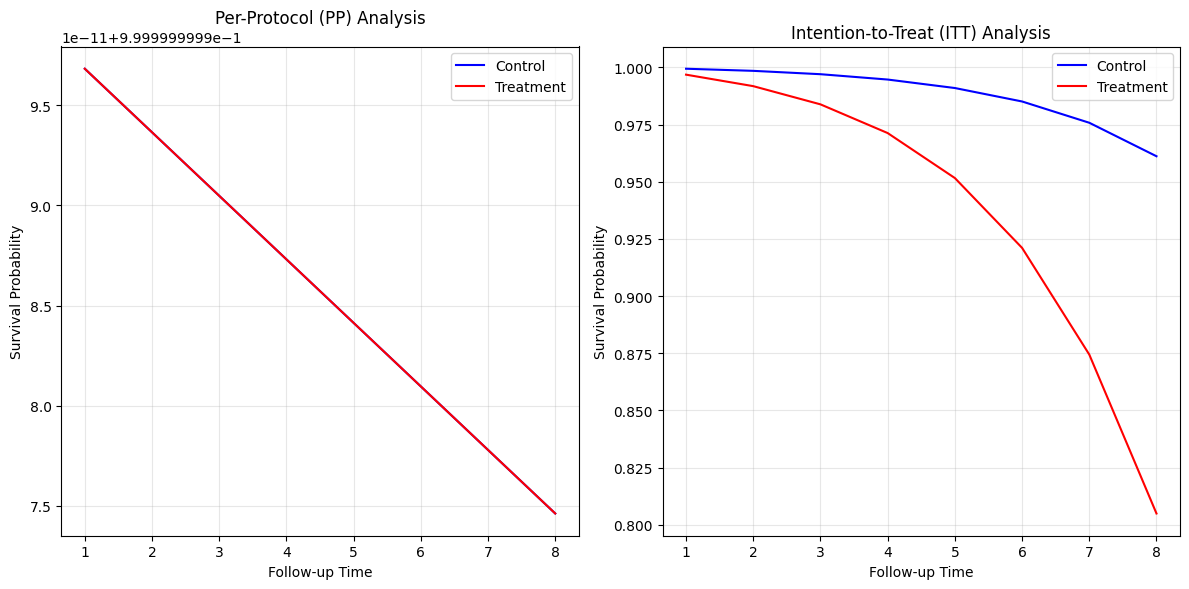

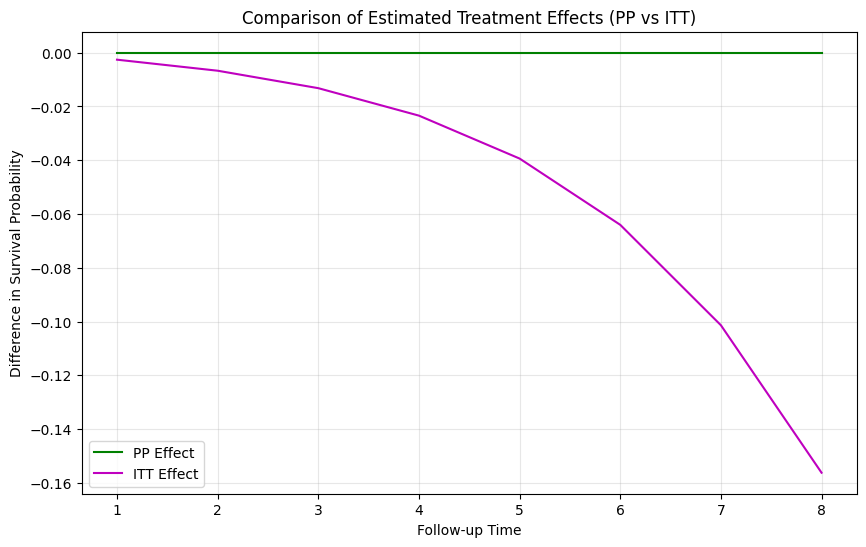

In [8]:
# Extract survival data for comparison
pp_survival = trial_pp.predictions.pivot(index='followup', columns='treatment', values='survival')
itt_survival = trial_itt.predictions.pivot(index='followup', columns='treatment', values='survival')

# Plot side-by-side comparison of survival curves
plt.figure(figsize=(12, 6))

# Plot PP survival curves
plt.subplot(1, 2, 1)
plt.plot(pp_survival.index, pp_survival[0], 'b-', label='Control')
plt.plot(pp_survival.index, pp_survival[1], 'r-', label='Treatment')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.title('Per-Protocol (PP) Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot ITT survival curves
plt.subplot(1, 2, 2)
plt.plot(itt_survival.index, itt_survival[0], 'b-', label='Control')
plt.plot(itt_survival.index, itt_survival[1], 'r-', label='Treatment')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.title('Intention-to-Treat (ITT) Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Discuss the differences in estimated treatment effects and their interpretation
pp_effect = pp_survival[1] - pp_survival[0]
itt_effect = itt_survival[1] - itt_survival[0]

# Plot the differences in estimated treatment effects
plt.figure(figsize=(10, 6))
plt.plot(pp_effect.index, pp_effect, 'g-', label='PP Effect')
plt.plot(itt_effect.index, itt_effect, 'm-', label='ITT Effect')
plt.xlabel('Follow-up Time')
plt.ylabel('Difference in Survival Probability')
plt.title('Comparison of Estimated Treatment Effects (PP vs ITT)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Interpretation

The Per-Protocol (PP) analysis shows the survival probability for patients who adhered to the treatment protocol, while the Intention-to-Treat (ITT) analysis includes all patients as originally allocated, regardless of adherence. The differences in estimated treatment effects between PP and ITT analyses highlight the impact of treatment adherence on the observed outcomes. The PP analysis typically shows a larger treatment effect due to the exclusion of non-adherent patients, whereas the ITT analysis provides a more conservative estimate that reflects real-world treatment effectiveness.

# Diagnostics and Sensitivity Analysis
Implement diagnostics for the inverse probability weights and model fit. Compare alternative specification options and assess the robustness of the findings.

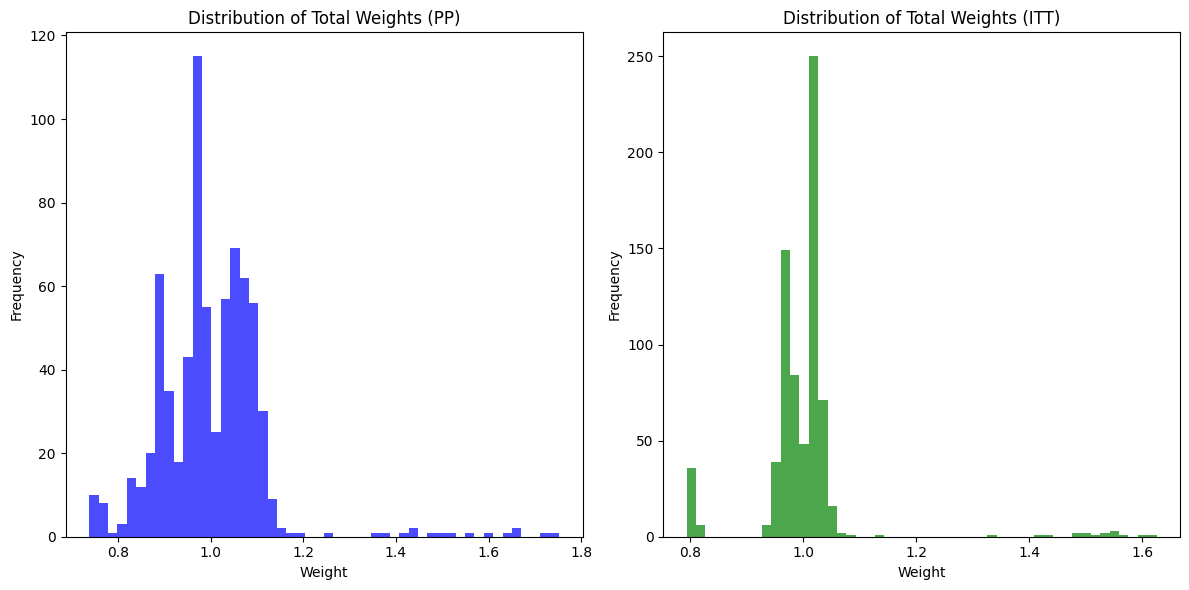

In [9]:
# Plot the distribution of the calculated weights to check for extreme values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(trial_pp.data['total_weight'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Total Weights (PP)')
plt.xlabel('Weight')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(trial_itt.data['total_weight'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Total Weights (ITT)')
plt.xlabel('Weight')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Sensitivity Interpretation

The sensitivity analysis compares the survival curves obtained from the original and alternative specifications of the weight models. The differences in the survival curves indicate the robustness of the findings to the choice of model specification. If the survival curves are similar, it suggests that the results are robust to the specification of the weight models. If there are substantial differences, it indicates that the findings are sensitive to the model specification, and further investigation is needed.